In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pptx import Presentation
from pptx.util import Inches

import os
os.makedirs("visuals", exist_ok=True)

conn = sqlite3.connect("northwind database.db")

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                    name
0             Categories
1        sqlite_sequence
2   CustomerCustomerDemo
3   CustomerDemographics
4              Customers
5              Employees
6    EmployeeTerritories
7          Order Details
8                 Orders
9               Products
10               Regions
11              Shippers
12             Suppliers
13           Territories
14      android_metadata


In [2]:
def peek_table(table_name, conn, n=5):
    query = f"SELECT * FROM '{table_name}' LIMIT {n};"
    return pd.read_sql_query(query, conn)

peek_table("Customers", conn)

,CustomerID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [3]:
peek_table("Orders", conn)

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2016-07-04,2016-08-01,2016-07-16,3,16.75,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,1,22.25,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2016-07-08,2016-08-05,2016-07-12,2,25.00,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2016-07-08,2016-08-05,2016-07-15,1,20.25,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2016-07-09,2016-08-06,2016-07-11,2,36.25,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [4]:
peek_table("Order Details", conn)

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [5]:
peek_table("Products", conn)

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [6]:
peek_table("Suppliers", conn)

,SupplierID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai\nMusashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


In [7]:
# Query: Top Customers by Sales
query = """
SELECT
c.CustomerID,
c.CompanyName,
ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS TotalSales
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN [Order Details] od ON o.OrderID = od.OrderID
GROUP BY c.CustomerID, c.CompanyName
ORDER BY TotalSales DESC
LIMIT 10;
"""
top_customers = pd.read_sql_query(query, conn)
top_customers

,CustomerID,CompanyName,TotalSales
0,BSBEV,B's Beverages,6154115.34
1,HUNGC,Hungry Coyote Import Store,5698023.67
2,RANCH,Rancho grande,5559110.08
3,GOURL,Gourmet Lanchonetes,5552309.80
4,ANATR,Ana Trujillo Emparedados y helados,5534356.65
5,RICAR,Ricardo Adocicados,5524517.31
6,FOLIG,Folies gourmandes,5505502.85
7,LETSS,Let's Stop N Shop,5462198.02
8,LILAS,LILA-Supermercado,5437438.34
9,PRINI,Princesa Isabel Vinhos,5436770.55


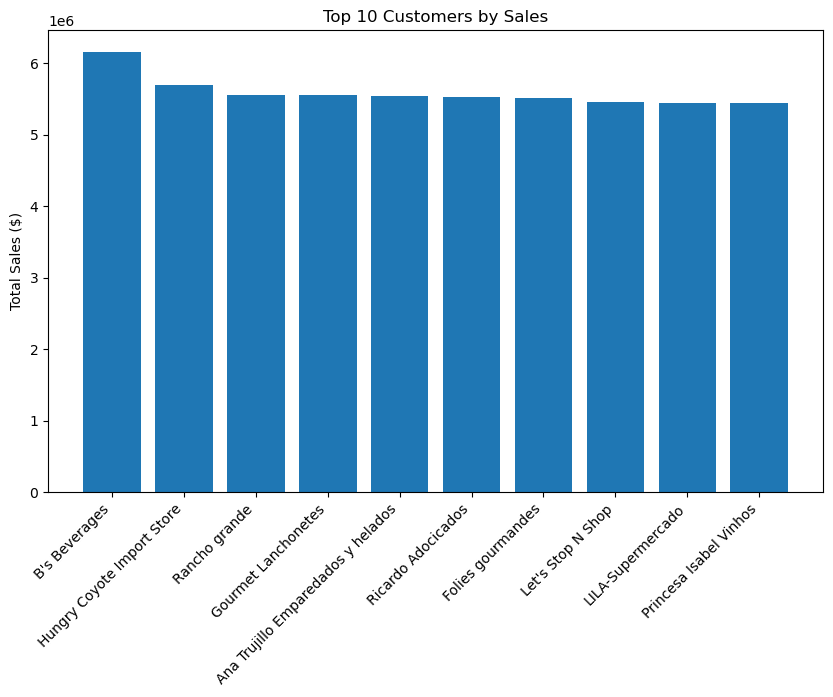

In [8]:
# Query: Bar Chart Showing Top Customers by Sales
plt.figure(figsize=(10,6))
plt.bar(top_customers["CompanyName"],
        top_customers["TotalSales"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Sales ($)")
plt.title("Top 10 Customers by Sales")

plt.savefig("visuals/top_10_customers_by_sales.png", bbox_inches="tight", dpi=200)
plt.show()

In [9]:
# Query: Yearly Sales Trend per Customer
query = """
SELECT
c.CustomerID,
c.CompanyName,
strftime('%Y', o.OrderDate) AS Year,
ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS TotalSales
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN "Order Details" od ON o.OrderID = od.OrderID
GROUP BY c.CustomerID, c.CompanyName, Year
HAVING TotalSales > 0
ORDER BY c.CustomerID, Year;
"""

df_trends = pd.read_sql(query, conn)
df_trends.head(15)

,CustomerID,CompanyName,Year,TotalSales
0,ALFKI,Alfreds Futterkiste,2012,143676.64
1,ALFKI,Alfreds Futterkiste,2013,261789.15
2,ALFKI,Alfreds Futterkiste,2014,195223.09
3,ALFKI,Alfreds Futterkiste,2015,323005.40
4,ALFKI,Alfreds Futterkiste,2016,393570.57
5,ALFKI,Alfreds Futterkiste,2017,428836.34
6,ALFKI,Alfreds Futterkiste,2018,217111.13
7,ALFKI,Alfreds Futterkiste,2019,489448.53
8,ALFKI,Alfreds Futterkiste,2020,460110.01
9,ALFKI,Alfreds Futterkiste,2021,448265.76


In [10]:
# Query: Top 5 Customers Sales Trends Over Time
top5 = (
    df_trends.groupby(["CustomerID", "CompanyName"])["TotalSales"]
    .sum()
    .nlargest(5)
    .reset_index()
)

top5_ids = top5["CustomerID"].tolist()

# Filter only those customers
df_top5_trends = df_trends[df_trends["CustomerID"].isin(top5_ids)]
df_top5_trends.head()

,CustomerID,CompanyName,Year,TotalSales
12,ANATR,Ana Trujillo Emparedados y helados,2012,115781.55
13,ANATR,Ana Trujillo Emparedados y helados,2013,409546.98
14,ANATR,Ana Trujillo Emparedados y helados,2014,428782.23
15,ANATR,Ana Trujillo Emparedados y helados,2015,659748.79
16,ANATR,Ana Trujillo Emparedados y helados,2016,587699.64


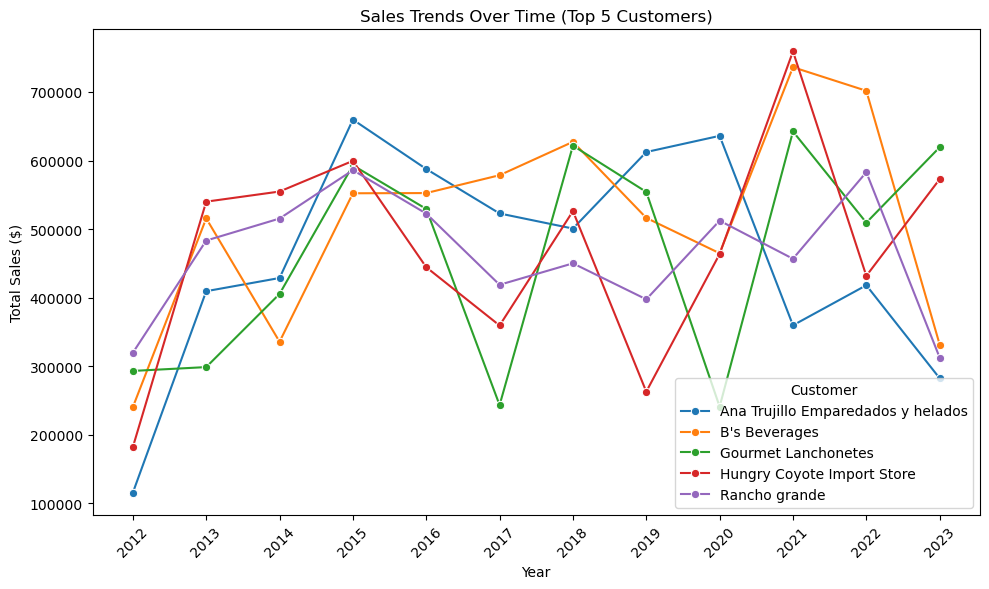

In [11]:
# Plot Line Chart Showing Top 5 Customers Sales Trends Over Time
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_top5_trends,
    x="Year", y="TotalSales",
    hue="CompanyName", marker="o"
)

plt.title("Sales Trends Over Time (Top 5 Customers)")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.legend(title="Customer")
plt.tight_layout()

plt.savefig("visuals/sales_trends_over_time_top5_customers.png", bbox_inches="tight", dpi=200)
plt.show()

In [12]:
# Query: sales per product
query = """
SELECT
p.ProductName,
c.CategoryName,
SUM(CAST(od.UnitPrice AS REAL) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS TotalSales
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY p.ProductName, c.CategoryName
ORDER BY TotalSales DESC
LIMIT 10;
"""

top_products = pd.read_sql_query(query, conn)
top_products

,ProductName,CategoryName,TotalSales
0,Côte de Blaye,Beverages,5.326590e+07
1,Thüringer Rostbratwurst,Meat/Poultry,2.462347e+07
2,Mishi Kobe Niku,Meat/Poultry,1.942304e+07
3,Sir Rodney's Marmalade,Confections,1.665381e+07
4,Carnarvon Tigers,Seafood,1.260467e+07
5,Raclette Courdavault,Dairy Products,1.121641e+07
6,Manjimup Dried Apples,Produce,1.066477e+07
7,Tarte au sucre,Confections,9.952936e+06
8,Ipoh Coffee,Beverages,9.333375e+06
9,Rössle Sauerkraut,Produce,9.252765e+06


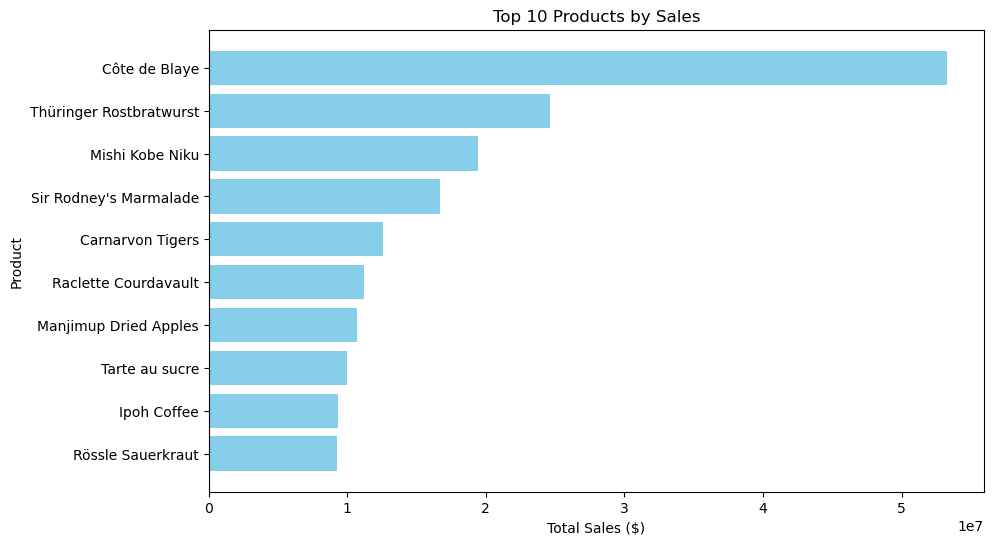

In [13]:
# Plot sales per product
plt.figure(figsize=(10,6))
plt.barh(top_products["ProductName"], top_products["TotalSales"], color="skyblue")
plt.xlabel("Total Sales ($)")
plt.ylabel("Product")
plt.title("Top 10 Products by Sales")
plt.gca().invert_yaxis() # so the highest bar shows at the top

plt.savefig("visuals/top10_products_by_sales.png", bbox_inches="tight", dpi=200)
plt.show()

In [14]:
# Query: Sales by Product Category
query = """
SELECT
c.CategoryName,
SUM(CAST(od.UnitPrice AS REAL) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS TotalSales
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY c.CategoryName
ORDER BY TotalSales DESC;
"""

category_sales = pd.read_sql_query(query, conn)
category_sales

,CategoryName,TotalSales
0,Beverages,9.216318e+07
1,Confections,6.633780e+07
2,Meat/Poultry,6.488115e+07
3,Dairy Products,5.801812e+07
4,Condiments,5.579513e+07
5,Seafood,4.992160e+07
6,Produce,3.270112e+07
7,Grains/Cereals,2.856853e+07


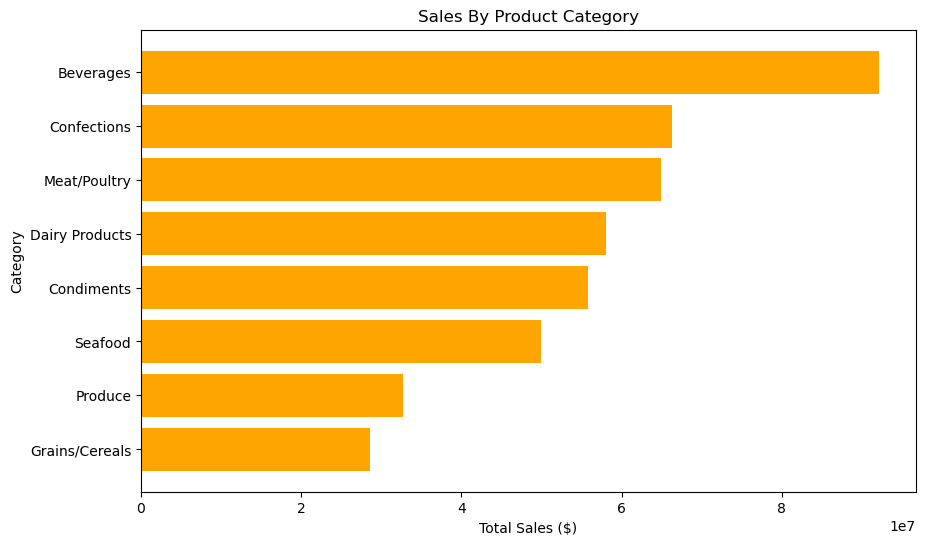

In [15]:
# Horizontal Bar Chart Showing Sales by Product Category
plt.figure(figsize=(10,6))
plt.barh(category_sales["CategoryName"], category_sales["TotalSales"], color="orange")
plt.xlabel("Total Sales ($)")
plt.ylabel("Category")
plt.title("Sales By Product Category")
plt.gca().invert_yaxis()

plt.savefig("visuals/sales_by_product_category.png", bbox_inches="tight", dpi=200)
plt.show()

In [16]:
# Query: Total Sales Over Time
query = """
SELECT 
strftime('%Y', o.OrderDate) AS Year, SUM(CAST(od.UnitPrice AS REAL) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS TotalSales
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
GROUP BY Year
ORDER BY Year;
"""

sales_trend = pd.read_sql_query(query, conn)
sales_trend

,Year,TotalSales
0,2012,1.882320e+07
1,2013,3.863312e+07
2,2014,3.887015e+07
3,2015,4.142346e+07
4,2016,4.056867e+07
5,2017,4.020990e+07
6,2018,3.832662e+07
7,2019,3.851696e+07
8,2020,3.886244e+07
9,2021,4.135555e+07


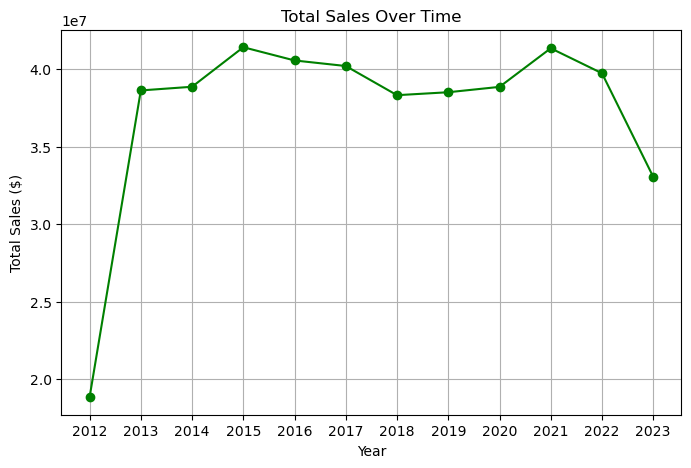

In [17]:
# Plot Line Chart Shawing Total Sales Over Time
plt.figure(figsize=(8,5))
plt.plot(sales_trend["Year"], sales_trend["TotalSales"], marker='o', color="green")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.title("Total Sales Over Time")
plt.grid(True)

plt.savefig("visuals/total_sales_over_time.png", bbox_inches="tight", dpi=200)
plt.show()

In [18]:
# Query: yearly sales by category
query = """
SELECT 
strftime('%Y', o.OrderDate) AS Year,
c.CategoryName,
SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY Year, c.CategoryName
ORDER BY Year, TotalSales DESC;
"""

category_trends = pd.read_sql_query(query, conn)

# Pivot so each category is a column
category_pivot = category_trends.pivot(index="Year", columns="CategoryName", values="TotalSales").fillna(0)
category_pivot.head()

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
Year,,,,,,,,
2012,3832061.25,2291584.800,2766970.81,2468091.40,1247321.75,2659703.09,1398658.35,2158810.270
2013,7770360.75,4849407.300,5759908.44,5061828.70,2477931.50,5546458.93,2858202.15,4309022.240
2014,7849069.00,4860618.000,5745252.40,5039262.90,2497940.25,5678110.80,2823964.30,4375930.480
2015,8421088.00,5136466.700,6137356.49,5469248.40,2612609.50,6028584.75,2995428.75,4622674.130
2016,8310426.00,5051886.885,6092657.42,5225892.95,2561295.42,5897979.28,2936024.33,4492510.075


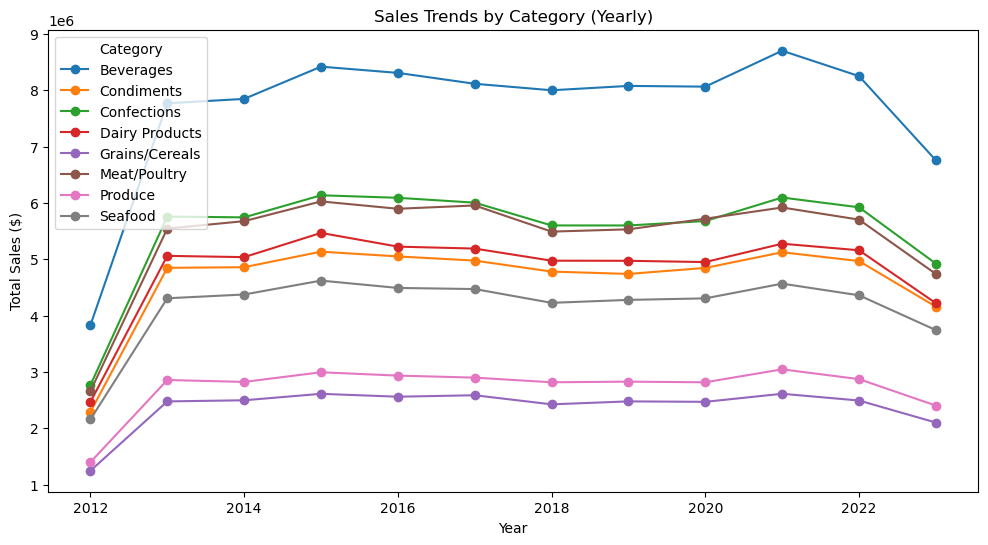

In [19]:
# Plot yearly sales by category
category_pivot.plot(kind="line", figsize=(12,6), marker="o")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.title("Sales Trends by Category (Yearly)")
plt.legend(title="Category")

plt.savefig("visuals/sales_trends_by_category.png", bbox_inches="tight", dpi=200)
plt.show()

In [20]:
# Query: Top Suppliers by Total Sales
query = """
SELECT
s.SupplierID,
s.CompanyName,
SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Suppliers s ON p.SupplierID = s.SupplierID
GROUP BY s.SupplierID, s.CompanyName
ORDER BY TotalSales DESC
LIMIT 10;
"""

top_suppliers = pd.read_sql_query(query, conn)
top_suppliers

,SupplierID,CompanyName,TotalSales
0,18,Aux joyeux ecclésiastiques,5.690022e+07
1,12,Plutzer Lebensmittelgroßmärkte AG,4.474509e+07
2,7,"Pavlova, Ltd.",3.588586e+07
3,4,Tokyo Traders,2.768235e+07
4,8,"Specialty Biscuits, Ltd.",2.309830e+07
5,3,Grandma Kelly's Homestead,1.922939e+07
6,24,"G'day, Mate",1.864782e+07
7,28,Gai pâturage,1.811685e+07
8,11,Heli Süßwaren GmbH & Co. KG,1.803231e+07
9,2,New Orleans Cajun Delights,1.638154e+07


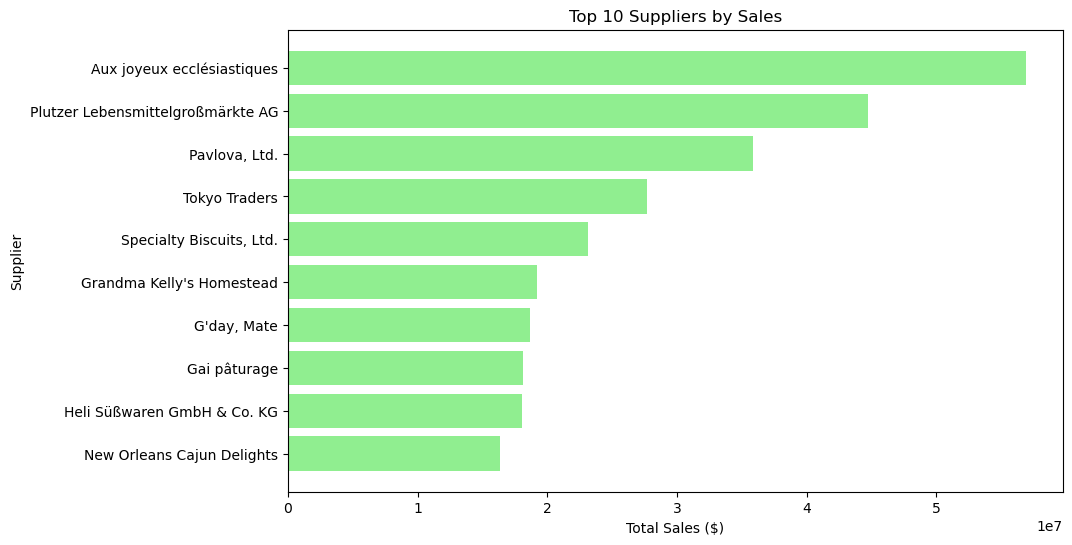

In [21]:
# Plot Top Suppliers by Total Sales
plt.figure(figsize=(10,6))
plt.barh(top_suppliers["CompanyName"], top_suppliers["TotalSales"], color="lightgreen")
plt.xlabel("Total Sales ($)")
plt.ylabel("Supplier")
plt.title("Top 10 Suppliers by Sales")
plt.gca().invert_yaxis()

plt.savefig("visuals/top10_suppliers_by_sales.png", bbox_inches="tight", dpi=200)
plt.show()

In [22]:
# Query: Sales Over Time (monthly)
query = """
SELECT 
strftime('%Y-%m', o.OrderDate) AS OrderMonth,
SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
GROUP BY OrderMonth
ORDER BY OrderMonth;
"""

monthly_sales = pd.read_sql_query(query, conn)
monthly_sales.head()

,OrderMonth,TotalSales
0,2012-07,2066219.40
1,2012-08,3556875.79
2,2012-09,3440144.98
3,2012-10,3201529.96
4,2012-11,2980494.74


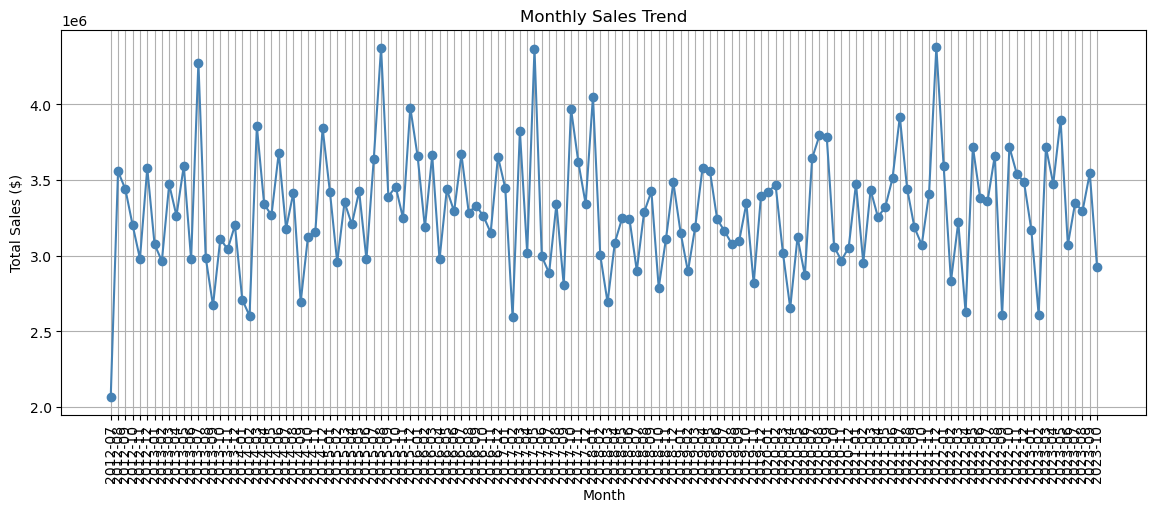

In [23]:
# Plot monthly sales over time
plt.figure(figsize=(14,5))
plt.plot(monthly_sales["OrderMonth"], monthly_sales["TotalSales"], marker="o", color="steelblue")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=90)
plt.grid(True)

plt.savefig("visuals/monthly_sales_trend.png", bbox_inches="tight", dpi=200)
plt.show()

In [24]:
# Query: top suppliers by sales
query = """
SELECT 
o.CustomerID,
c.CompanyName,
AVG(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS AvgOrderValue
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
GROUP BY o.CustomerID, c.CompanyName
ORDER BY AvgOrderValue DESC
LIMIT 10;
"""

avg_order_value = pd.read_sql_query(query, conn)
avg_order_value

,CustomerID,CompanyName,AvgOrderValue
0,HANAR,Hanari Carnes,755.250601
1,BOLID,Bólido Comidas preparadas,754.551921
2,MAISD,Maison Dewey,753.532988
3,VINET,Vins et alcools Chevalier,752.904811
4,FAMIA,Familia Arquibaldo,750.886567
5,RANCH,Rancho grande,750.622479
6,GROSR,GROSELLA-Restaurante,749.845047
7,EASTC,Eastern Connection,749.382615
8,PERIC,Pericles Comidas clásicas,749.272053
9,SAVEA,Save-a-lot Markets,748.851102


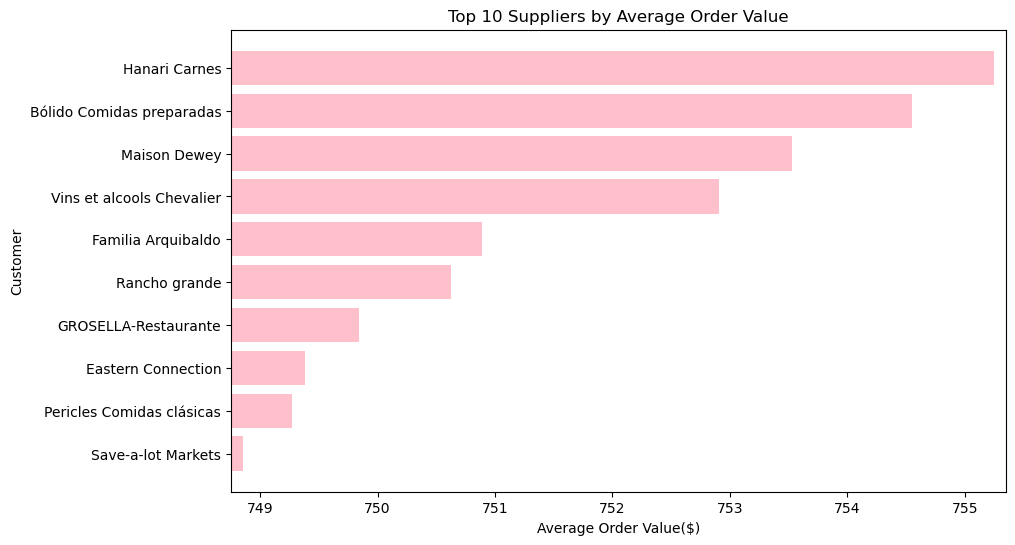

In [25]:
# Plot top suppliers by sales
plt.figure(figsize=(10,6))
plt.barh(avg_order_value["CompanyName"], avg_order_value["AvgOrderValue"], color="pink")
plt.xlabel("Average Order Value($)")
plt.ylabel("Customer")
plt.title("Top 10 Suppliers by Average Order Value")
plt.gca().invert_yaxis()

# Zoom in axis
min_val = avg_order_value["AvgOrderValue"].min() - 0.1
max_val = avg_order_value["AvgOrderValue"].max() + 0.1
plt.xlim(min_val, max_val)

plt.savefig("visuals/top10_suppliers_by_average_order_value.png", bbox_inches="tight", dpi=200)
plt.show()

In [26]:
# Get total sales per customer again
query = """
SELECT 
o.CustomerID,
c.CompanyName,
SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
GROUP BY o.CustomerID, c.CompanyName;
"""

customer_sales = pd.read_sql_query(query, conn)

# Define Percentiles
high_threshold = customer_sales["TotalSales"].quantile(0.80)
low_threshold = customer_sales["TotalSales"].quantile(0.30)

def segment_customer(sales):
    if sales >= high_threshold:
        return "High Value"
    elif sales >= low_threshold:
        return "Medium Value"
    else:
        return "Low Value"

customer_sales["Segment"] = customer_sales["TotalSales"].apply(segment_customer)

# Count customers in each segment
segment_counts = customer_sales["Segment"].value_counts()
segment_counts

Segment
Medium Value    46
Low Value       28
High Value      19
Name: count, dtype: int64

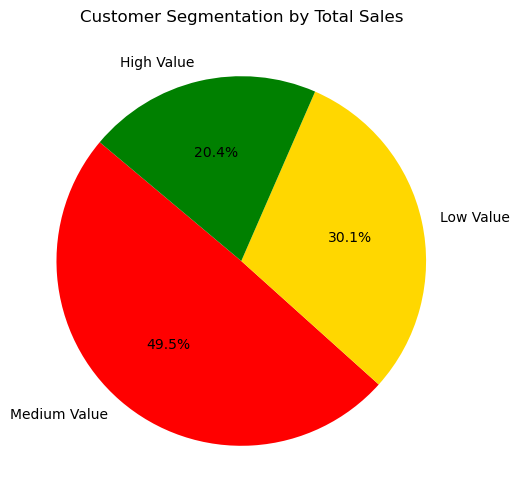

,CustomerID,CompanyName,TotalSales,Segment
0,ALFKI,Alfreds Futterkiste,3.965465e+06,Low Value
1,ANATR,Ana Trujillo Emparedados y helados,5.534357e+06,High Value
2,ANTON,Antonio Moreno Taquería,4.311774e+06,Low Value
3,AROUT,Around the Horn,4.251822e+06,Low Value
4,BERGS,Berglunds snabbköp,4.833399e+06,Medium Value
5,BLAUS,Blauer See Delikatessen,4.411618e+06,Low Value
6,BLONP,Blondesddsl père et fils,4.705978e+06,Medium Value
7,BOLID,Bólido Comidas preparadas,5.398064e+06,High Value
8,BONAP,Bon app',4.725685e+06,Medium Value
9,BOTTM,Bottom-Dollar Markets,5.064202e+06,Medium Value


In [27]:
# Plot customer segmentation by total sales
plt.figure(figsize=(6,6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=["red", "gold", "green"])
plt.title("Customer Segmentation by Total Sales")

plt.savefig("visuals/customer_segmentation_by_total_sales.png", bbox_inches="tight", dpi=200)
plt.show()

customer_sales.head(10)

In [28]:
# Query for Recency, Frequency, Monetary
query = """
SELECT 
c.CustomerID,
c.CompanyName,
MAX(o.OrderDate) AS LastOrderDate,
COUNT(DISTINCT o.OrderID) AS Frequency,
SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS Monetary
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN [Order Details] od ON o.OrderID = od.OrderID
GROUP BY c.CustomerID, c.CompanyName;
"""

rfm = pd.read_sql_query(query, conn)

# Convert LastOrderDate to datetime
rfm["LastOrderDate"] = pd.to_datetime(rfm["LastOrderDate"])

#Assume analysis date = latest order date in dataset
analysis_date = rfm["LastOrderDate"].max()

# Recency = days since last order
rfm["Recency"] = (analysis_date - rfm["LastOrderDate"]).dt.days

# Select only useful columns
rfm = rfm[["CustomerID", "CompanyName", "Recency", "Frequency", "Monetary"]]

# Quick look
rfm.head(10)

,CustomerID,CompanyName,Recency,Frequency,Monetary
0,ALFKI,Alfreds Futterkiste,12,163,3.965465e+06
1,ANATR,Ana Trujillo Emparedados y helados,4,195,5.534357e+06
2,ANTON,Antonio Moreno Taquería,5,163,4.311774e+06
3,AROUT,Around the Horn,53,156,4.251822e+06
4,BERGS,Berglunds snabbköp,5,178,4.833399e+06
5,BLAUS,Blauer See Delikatessen,45,164,4.411618e+06
6,BLONP,Blondesddsl père et fils,11,165,4.705978e+06
7,BOLID,Bólido Comidas preparadas,0,182,5.398064e+06
8,BONAP,Bon app',13,167,4.725685e+06
9,BOTTM,Bottom-Dollar Markets,43,185,5.064202e+06


In [29]:
# RFm Scoring

# For Recency, lower is better (recent = good)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)

# For Frequency & Monetary, higher is better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

# Combine scores into a single code
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

# Average score to rank customers overall
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].mean(axis=1)

rfm.head(10)

,CustomerID,CompanyName,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,ALFKI,Alfreds Futterkiste,12,163,3.965465e+06,4,1,1,411,2.000000
1,ANATR,Ana Trujillo Emparedados y helados,4,195,5.534357e+06,5,5,5,555,5.000000
2,ANTON,Antonio Moreno Taquería,5,163,4.311774e+06,5,1,1,511,2.333333
3,AROUT,Around the Horn,53,156,4.251822e+06,1,1,1,111,1.000000
4,BERGS,Berglunds snabbköp,5,178,4.833399e+06,5,4,3,543,4.000000
5,BLAUS,Blauer See Delikatessen,45,164,4.411618e+06,1,2,1,121,1.333333
6,BLONP,Blondesddsl père et fils,11,165,4.705978e+06,4,2,2,422,2.666667
7,BOLID,Bólido Comidas preparadas,0,182,5.398064e+06,5,4,5,545,4.666667
8,BONAP,Bon app',13,167,4.725685e+06,3,2,3,323,2.666667
9,BOTTM,Bottom-Dollar Markets,43,185,5.064202e+06,1,4,4,144,3.000000


In [30]:
# Function to map RFM Score to segment
def rfm_category(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return "Champions"
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return "Loyal Customers"
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return "Potential Loyalists"
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return "At Risk"
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return "Hibernating / Lost"
    else:
        return "Need Attention"

# Apply mapping
rfm['RFM_Category'] = rfm.apply(rfm_category, axis=1)

# Count per segment
category_counts = rfm['RFM_Category'].value_counts()
category_counts

RFM_Category
Need Attention         20
Hibernating / Lost     18
Loyal Customers        18
Champions              13
Potential Loyalists    12
At Risk                12
Name: count, dtype: int64

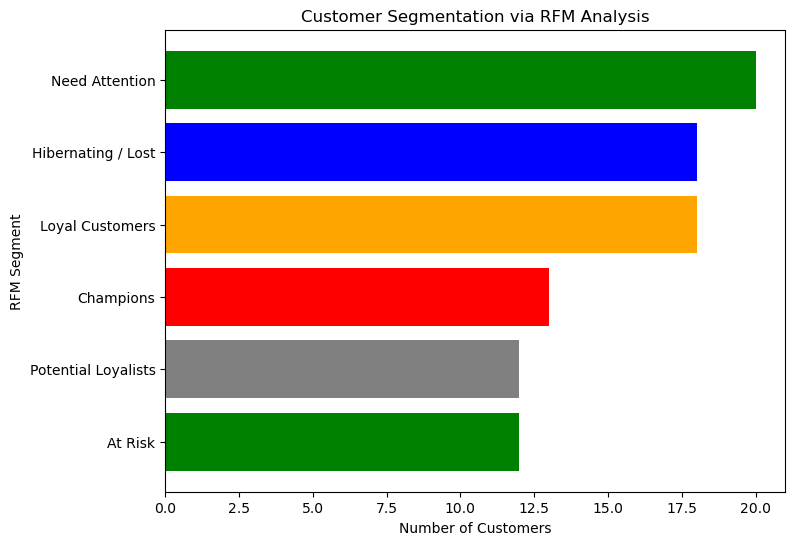

,CustomerID,CompanyName,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,RFM_Category
0,ALFKI,Alfreds Futterkiste,12,163,3.965465e+06,4,1,1,411,2.000000,Potential Loyalists
1,ANATR,Ana Trujillo Emparedados y helados,4,195,5.534357e+06,5,5,5,555,5.000000,Champions
2,ANTON,Antonio Moreno Taquería,5,163,4.311774e+06,5,1,1,511,2.333333,Potential Loyalists
3,AROUT,Around the Horn,53,156,4.251822e+06,1,1,1,111,1.000000,Hibernating / Lost
4,BERGS,Berglunds snabbköp,5,178,4.833399e+06,5,4,3,543,4.000000,Loyal Customers
5,BLAUS,Blauer See Delikatessen,45,164,4.411618e+06,1,2,1,121,1.333333,Hibernating / Lost
6,BLONP,Blondesddsl père et fils,11,165,4.705978e+06,4,2,2,422,2.666667,Potential Loyalists
7,BOLID,Bólido Comidas preparadas,0,182,5.398064e+06,5,4,5,545,4.666667,Champions
8,BONAP,Bon app',13,167,4.725685e+06,3,2,3,323,2.666667,Need Attention
9,BOTTM,Bottom-Dollar Markets,43,185,5.064202e+06,1,4,4,144,3.000000,At Risk


In [31]:
# Plot customer segmentation via rfm analysis
plt.figure(figsize=(8,6))
plt.barh(category_counts.index, category_counts.values, color=['green','blue','orange','red','gray'])
plt.xlabel("Number of Customers")
plt.ylabel("RFM Segment")
plt.title("Customer Segmentation via RFM Analysis")
plt.gca().invert_yaxis()

plt.savefig("visuals/customer_segmentation_via_rfm_analysis.png", bbox_inches="tight", dpi=200)
plt.show()

rfm.head(10)

In [32]:
# Sum total sales per RFM segment
segment_revenue = rfm.groupby("RFM_Category")["Monetary"].sum().sort_values(ascending=False)
segment_revenue

RFM_Category
Need Attention         9.242817e+07
Loyal Customers        8.955169e+07
Hibernating / Lost     8.226320e+07
Champions              7.027808e+07
At Risk                6.041684e+07
Potential Loyalists    5.344865e+07
Name: Monetary, dtype: float64

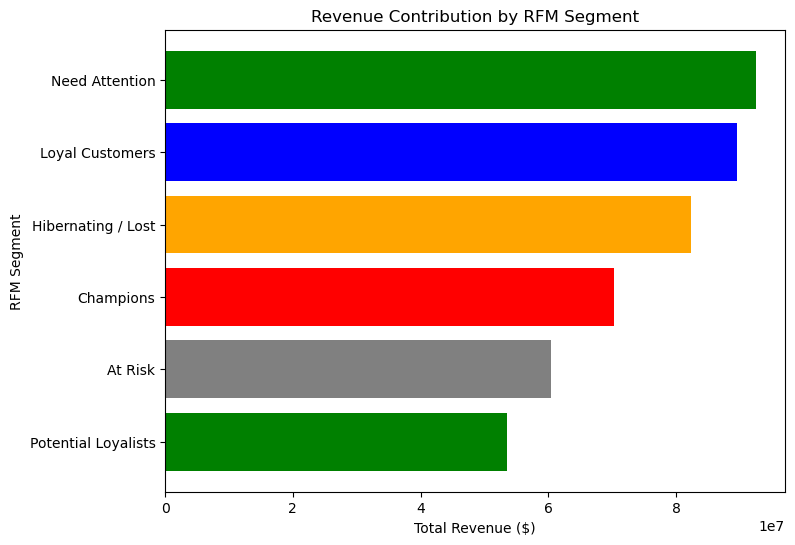

In [33]:
# Plot total sales per RFM segment
plt.figure(figsize=(8,6))
plt.barh(segment_revenue.index, segment_revenue.values, color=['green','blue','orange','red','gray'])
plt.xlabel("Total Revenue ($)")
plt.ylabel("RFM Segment")
plt.title("Revenue Contribution by RFM Segment")
plt.gca().invert_yaxis()

plt.savefig("visuals/revenue_contribution_by_rfm_segment.png", bbox_inches="tight", dpi=200)
plt.show()

In [34]:
# Ensure monthly_sales has 'OrderMonth' as datetime
monthly_sales['OrderMonth'] = pd.to_datetime(monthly_sales['OrderMonth'])

# Set datetime as index
monthly_sales.set_index('OrderMonth', inplace=True)

# Rolling average (3-month) to smooth trend
monthly_sales['Rolling_Avg'] = monthly_sales['TotalSales'].rolling(3).mean()
monthly_sales['Rolling_Avg']

OrderMonth
2012-07-01             NaN
2012-08-01             NaN
2012-09-01    3.021080e+06
2012-10-01    3.399517e+06
2012-11-01    3.207390e+06
                  ...     
2023-06-01    3.481091e+06
2023-07-01    3.439556e+06
2023-08-01    3.238428e+06
2023-09-01    3.396065e+06
2023-10-01    3.253741e+06
Name: Rolling_Avg, Length: 136, dtype: float64

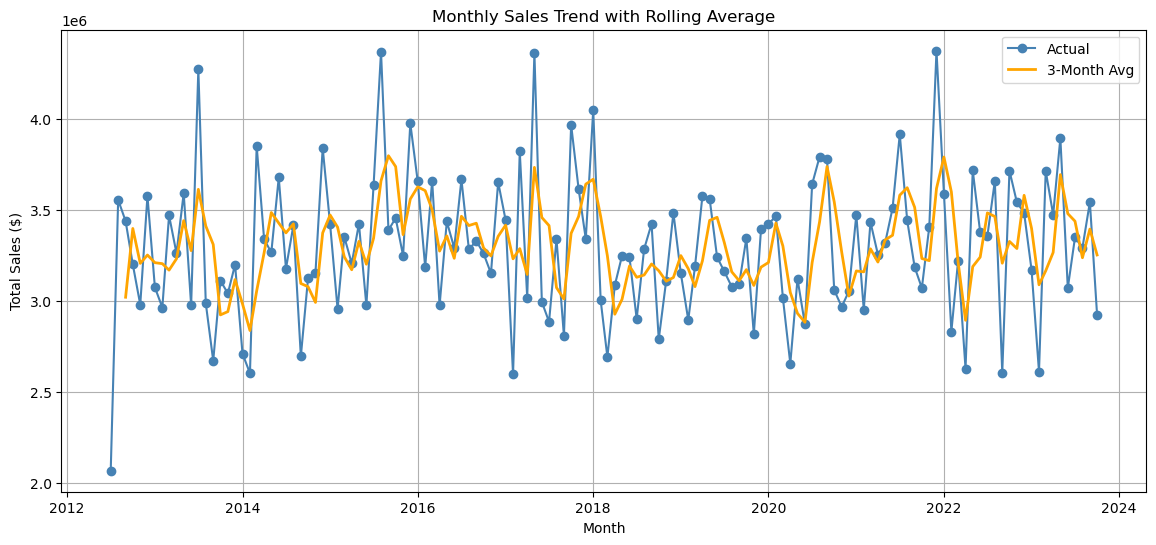

In [35]:
# Plot actual + smoothed
plt.figure(figsize=(14,6))
plt.plot(monthly_sales.index, monthly_sales['TotalSales'], marker='o', label='Actual', color='steelblue')
plt.plot(monthly_sales.index, monthly_sales['Rolling_Avg'], label='3-Month Avg', color='orange', linewidth=2)
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.title("Monthly Sales Trend with Rolling Average")
plt.legend()
plt.grid(True)

plt.savefig("visuals/monthly_sales_trend_with_rolling_average.png", bbox_inches="tight", dpi=200)
plt.show()

In [36]:
# Query: delivery times by supplier
query = """
SELECT 
    s.CompanyName AS Supplier,
    AVG(julianday(o.ShippedDate) - julianday(o.OrderDate)) AS AvgDeliveryDays,
    COUNT(o.OrderID) AS NumOrders
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Products p ON od.ProductID = p.ProductID
JOIN Suppliers s ON p.SupplierID = s.SupplierID
WHERE o.ShippedDate IS NOT NULL AND o.OrderDate IS NOT NULL
GROUP BY s.CompanyName
ORDER BY AvgDeliveryDays ASC;
"""

supplier_delivery = pd.read_sql_query(query, conn)
supplier_delivery.head(10)

,Supplier,AvgDeliveryDays,NumOrders
0,New Orleans Cajun Delights,7.758446,31676
1,PB Knäckebröd AB,7.770337,15916
2,Ma Maison,7.776993,15872
3,New England Seafood Cannery,7.782870,15818
4,Zaanse Snoepfabriek,7.785976,15677
5,Lyngbysild,7.788486,15738
6,Formaggi Fortini s.r.l.,7.789974,23691
7,Gai pâturage,7.791410,15906
8,Nord-Ost-Fisch Handelsgesellschaft mbH,7.797594,7951
9,"Pavlova, Ltd.",7.803124,39591


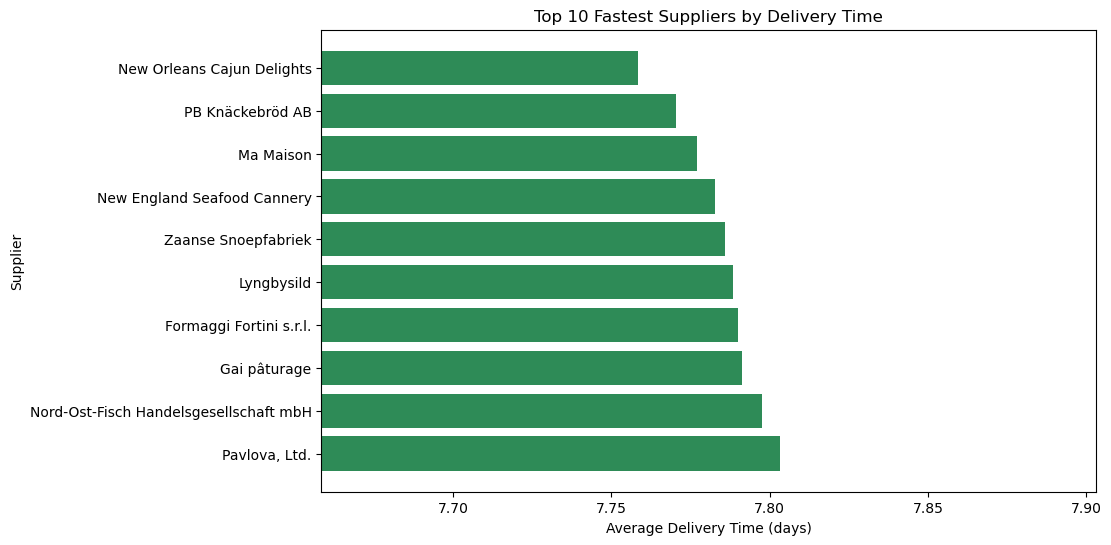

In [37]:
# Top 10 fastest suppliers
fastest_suppliers = supplier_delivery.nsmallest(10, "AvgDeliveryDays")

plt.figure(figsize=(10,6))
plt.barh(fastest_suppliers["Supplier"], fastest_suppliers["AvgDeliveryDays"], color="seagreen")
plt.xlabel("Average Delivery Time (days)")
plt.ylabel("Supplier")
plt.title("Top 10 Fastest Suppliers by Delivery Time")
plt.gca().invert_yaxis()

# Zoom in axis
min_val = fastest_suppliers["AvgDeliveryDays"].min() - 0.1
max_val = fastest_suppliers["AvgDeliveryDays"].max() + 0.1
plt.xlim(min_val, max_val)

plt.savefig("visuals/top10_fastest_suppliers_by_delivery_time.png", bbox_inches="tight", dpi=200)
plt.show()

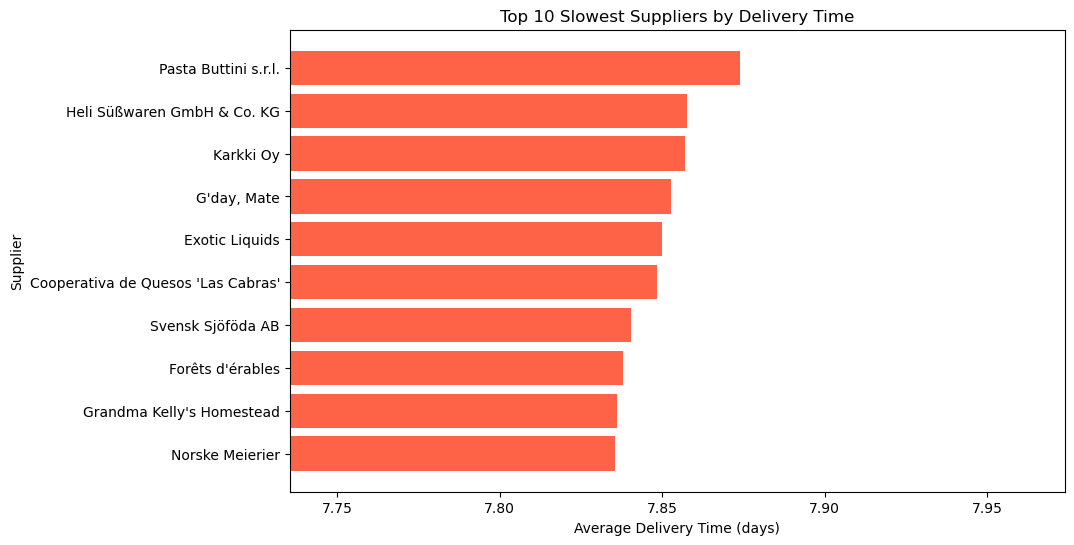

In [38]:
# Top 10 slowest suppliers
slowest_suppliers = supplier_delivery.nlargest(10, "AvgDeliveryDays")

plt.figure(figsize=(10,6))
plt.barh(slowest_suppliers["Supplier"], slowest_suppliers["AvgDeliveryDays"], color="tomato")
plt.xlabel("Average Delivery Time (days)")
plt.ylabel("Supplier")
plt.title("Top 10 Slowest Suppliers by Delivery Time")
plt.gca().invert_yaxis()

# Zoom in axis
min_val = slowest_suppliers["AvgDeliveryDays"].min() - 0.1
max_val = slowest_suppliers["AvgDeliveryDays"].max() + 0.1
plt.xlim(min_val, max_val)

plt.savefig("visuals/top_10_slowest_suppliers_by_delivery_time.png", bbox_inches="tight", dpi=200)
plt.show()

In [39]:
# Create supplier_perf (supplier-level total sales + average delivery days)
query = """
SELECT 
    s.SupplierID,
    s.CompanyName,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales,
    AVG(julianday(o.ShippedDate) - julianday(o.OrderDate)) AS AvgDeliveryDays
FROM Suppliers s
JOIN Products p ON s.SupplierID = p.SupplierID
JOIN [Order Details] od ON p.ProductID = od.ProductID
JOIN Orders o ON od.OrderID = o.OrderID
WHERE o.ShippedDate IS NOT NULL
GROUP BY s.SupplierID, s.CompanyName
ORDER BY TotalSales DESC;
"""

supplier_perf = pd.read_sql_query(query, conn)
supplier_perf.head()

,SupplierID,CompanyName,TotalSales,AvgDeliveryDays
0,18,Aux joyeux ecclésiastiques,5.690019e+07,7.834723
1,12,Plutzer Lebensmittelgroßmärkte AG,4.473608e+07,7.821282
2,7,"Pavlova, Ltd.",3.588454e+07,7.803124
3,4,Tokyo Traders,2.768232e+07,7.822846
4,8,"Specialty Biscuits, Ltd.",2.309793e+07,7.818306


In [40]:
# Calculate thresholds (mean delivery days and mean total sales)
avg_delivery = supplier_perf["AvgDeliveryDays"].mean()
avg_sales = supplier_perf["TotalSales"].mean()

# Function to classify suppliers
def classify_supplier(row):
    if row["TotalSales"] >= avg_sales and row["AvgDeliveryDays"] <= avg_delivery:
        return "Fast & Reliable"
    elif row["TotalSales"] >= avg_sales and row["AvgDeliveryDays"] > avg_delivery:
        return "Slow but Important"
    elif row["TotalSales"] < avg_sales and row["AvgDeliveryDays"] <= avg_delivery:
        return "Minor Players"
    else:
        return "Slow & Low Impact"

# Apply classification
supplier_perf["Category"] = supplier_perf.apply(classify_supplier, axis=1)
supplier_perf["Category"].head()

0    Slow but Important
1    Slow but Important
2       Fast & Reliable
3    Slow but Important
4    Slow but Important
Name: Category, dtype: object

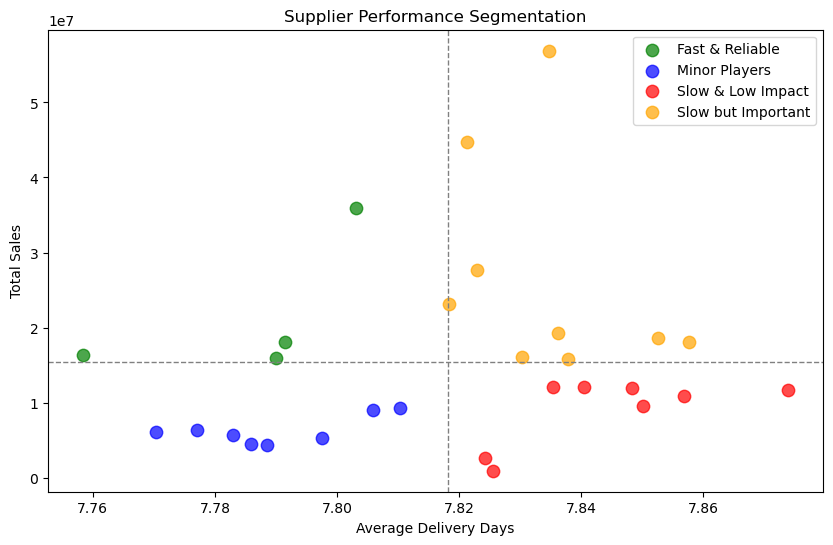

In [41]:
# Plot with categories
plt.figure(figsize=(10,6))
colors = {
    "Fast & Reliable": "green",
    "Slow but Important": "orange",
    "Minor Players": "blue",
    "Slow & Low Impact": "red"
}

for cat, group in supplier_perf.groupby("Category"):
    plt.scatter(group["AvgDeliveryDays"], group["TotalSales"], 
                label=cat, color=colors[cat], alpha=0.7, s=80)

plt.axhline(avg_sales, color="gray", linestyle="--", linewidth=1)
plt.axvline(avg_delivery, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Average Delivery Days")
plt.ylabel("Total Sales")
plt.title("Supplier Performance Segmentation")
plt.legend()

plt.savefig("visuals/supplier_performance_segmentation.png", bbox_inches="tight", dpi=200)
plt.show()

In [42]:
# Prepare monthly sales series
query = """
SELECT 
    strftime('%Y-%m', o.OrderDate) AS OrderMonth,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
GROUP BY OrderMonth
ORDER BY OrderMonth;
"""

monthly_sales = pd.read_sql_query(query, conn)
monthly_sales["OrderMonth"] = pd.to_datetime(monthly_sales["OrderMonth"])
monthly_sales.set_index("OrderMonth", inplace=True)

# Fit ARIMA model
model = ARIMA(monthly_sales["TotalSales"], order=(1,1,1))  # (p,d,q) order can be tuned
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)
forecast

C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-11-01    3.257437e+06
2023-12-01    3.312417e+06
2024-01-01    3.321466e+06
2024-02-01    3.322955e+06
2024-03-01    3.323200e+06
2024-04-01    3.323240e+06
2024-05-01    3.323247e+06
2024-06-01    3.323248e+06
2024-07-01    3.323248e+06
2024-08-01    3.323248e+06
2024-09-01    3.323248e+06
2024-10-01    3.323248e+06
Freq: MS, Name: predicted_mean, dtype: float64

C:\Users\Hp\AppData\Local\Temp\ipykernel_24000\1506933028.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq="M"), forecast, label="Forecast", color="red")


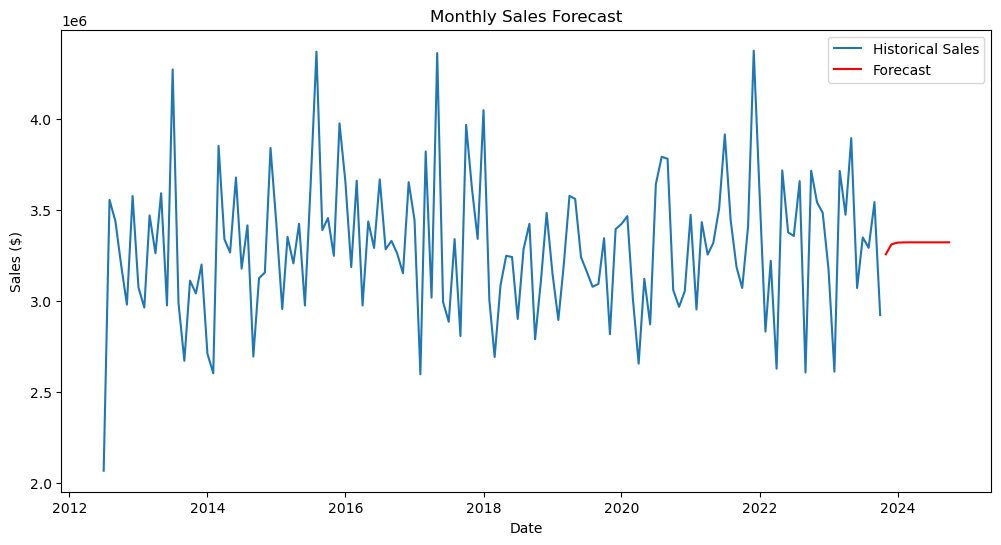

In [43]:
# Plot monthly sales series with forecasting
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales["TotalSales"], label="Historical Sales")
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq="M"), forecast, label="Forecast", color="red")
plt.title("Monthly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()

plt.savefig("visuals/monthly_sales_forecast.png", bbox_inches="tight", dpi=200)
plt.show()

C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\miniconda3\envs\trade_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE: 266004.08
RMSE: 335917.71
MAPE: 8.32%


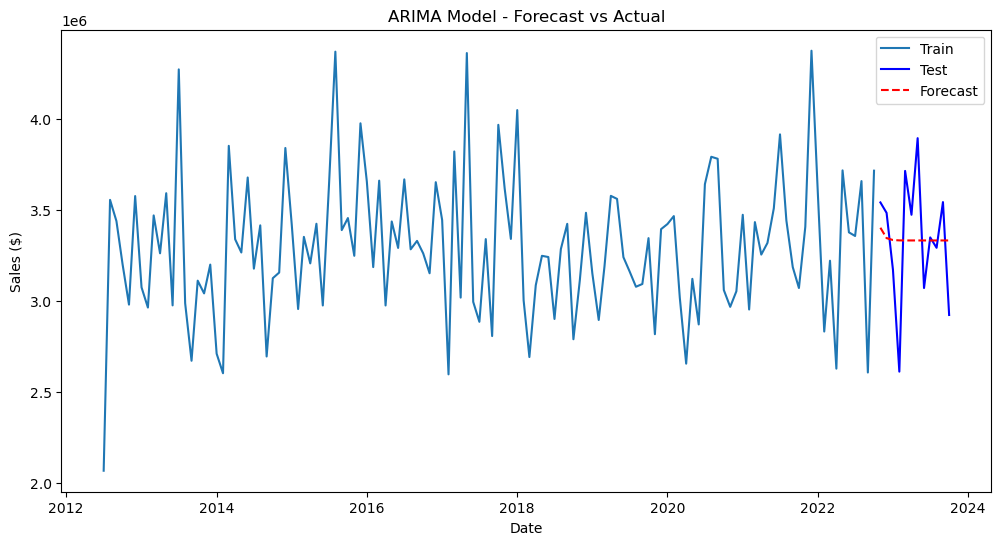

In [44]:
# To test forecasting accuracy

# Step 1: Train-test split (last 12 months as test)
train = monthly_sales.iloc[:-12]
test = monthly_sales.iloc[-12:]

# Step 2: Fit ARIMA on train data
model = ARIMA(train["TotalSales"], order=(1,1,1))
model_fit = model.fit()

# Step 3: Forecast same length as test
forecast = model_fit.forecast(steps=len(test))

# Step 4: Evaluate accuracy
mae = mean_absolute_error(test["TotalSales"], forecast)
rmse = np.sqrt(mean_squared_error(test["TotalSales"], forecast))
mape = np.mean(np.abs((test["TotalSales"] - forecast) / test["TotalSales"])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Step 5: Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train["TotalSales"], label="Train")
plt.plot(test.index, test["TotalSales"], label="Test", color="blue")
plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="--")
plt.title("ARIMA Model - Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()

plt.savefig("visuals/arima_model_forecast_vs_actual.png", bbox_inches="tight", dpi=200)
plt.show()

In [45]:
# Profitability by product and category

query = """
SELECT 
    p.ProductName,
    c.CategoryName,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS Revenue,
    SUM((od.UnitPrice * 0.6) * od.Quantity * (1 - od.Discount)) AS Cost,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) -
    SUM((od.UnitPrice * 0.6) * od.Quantity * (1 - od.Discount)) AS Profit
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY p.ProductName, c.CategoryName
ORDER BY Profit DESC
LIMIT 10;
"""

profit_products = pd.read_sql_query(query, conn)
profit_products

,ProductName,CategoryName,Revenue,Cost,Profit
0,Côte de Blaye,Beverages,5.326590e+07,3.195954e+07,2.130636e+07
1,Thüringer Rostbratwurst,Meat/Poultry,2.462347e+07,1.477408e+07,9.849388e+06
2,Mishi Kobe Niku,Meat/Poultry,1.942304e+07,1.165382e+07,7.769215e+06
3,Sir Rodney's Marmalade,Confections,1.665381e+07,9.992284e+06,6.661523e+06
4,Carnarvon Tigers,Seafood,1.260467e+07,7.562803e+06,5.041869e+06
5,Raclette Courdavault,Dairy Products,1.121641e+07,6.729846e+06,4.486564e+06
6,Manjimup Dried Apples,Produce,1.066477e+07,6.398861e+06,4.265907e+06
7,Tarte au sucre,Confections,9.952936e+06,5.971762e+06,3.981174e+06
8,Ipoh Coffee,Beverages,9.333375e+06,5.600025e+06,3.733350e+06
9,Rössle Sauerkraut,Produce,9.252765e+06,5.551659e+06,3.701106e+06


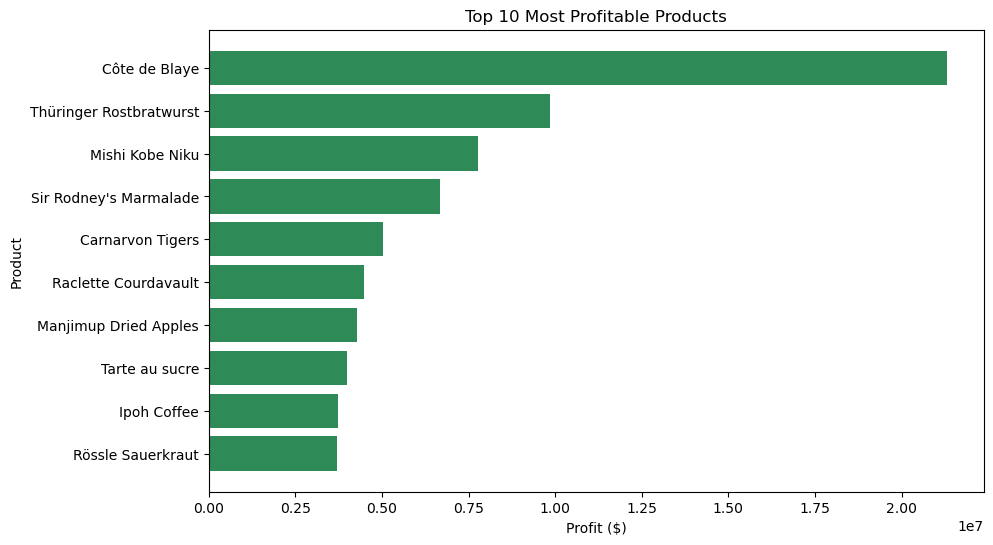

In [46]:
# Visualise Profitability by product and category
plt.figure(figsize=(10,6))
plt.barh(profit_products["ProductName"], profit_products["Profit"], color="seagreen")
plt.xlabel("Profit ($)")
plt.ylabel("Product")
plt.title("Top 10 Most Profitable Products")
plt.gca().invert_yaxis()  # biggest profit at top

plt.savefig("visuals/top10_most_profitable_products.png", bbox_inches="tight", dpi=200)
plt.show()

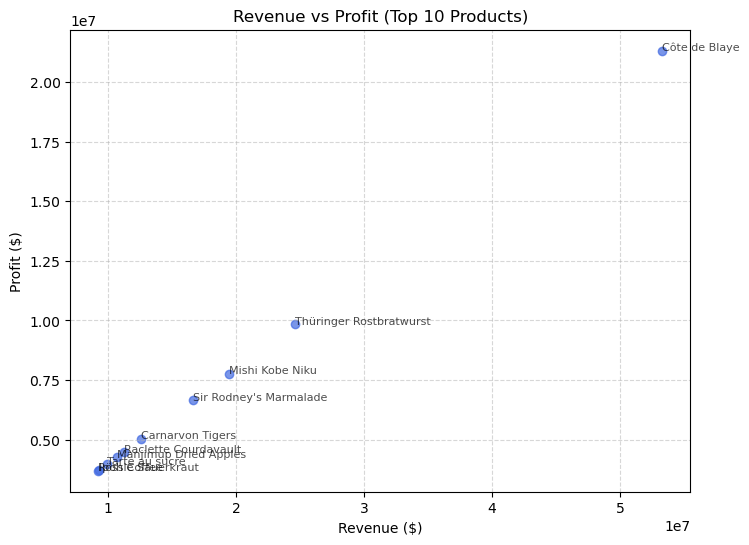

In [47]:
# Revenue vs Profit scatterplot
plt.figure(figsize=(8,6))
plt.scatter(profit_products["Revenue"], profit_products["Profit"], 
            color="royalblue", alpha=0.7)

for i, txt in enumerate(profit_products["ProductName"]):
    plt.annotate(txt, (profit_products["Revenue"].iloc[i], profit_products["Profit"].iloc[i]),
                 fontsize=8, alpha=0.7)

plt.xlabel("Revenue ($)")
plt.ylabel("Profit ($)")
plt.title("Revenue vs Profit (Top 10 Products)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig("visuals/revenue_vs_png.png", bbox_inches="tight", dpi=200)
plt.show()

In [48]:
# Compute profit for all products
query_all = """
SELECT 
    p.ProductID,
    p.ProductName,
    c.CategoryName,
    SUM(CAST(od.UnitPrice AS REAL) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS Revenue,
    SUM((CAST(od.UnitPrice AS REAL) * 0.6) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS Cost,
    SUM(CAST(od.UnitPrice AS REAL) * od.Quantity * (1 - CAST(od.Discount AS REAL))) -
    SUM((CAST(od.UnitPrice AS REAL) * 0.6) * od.Quantity * (1 - CAST(od.Discount AS REAL))) AS Profit
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
LEFT JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY p.ProductID, p.ProductName, c.CategoryName
ORDER BY Revenue DESC;
"""
profit_all = pd.read_sql_query(query_all, conn)
profit_all.head()

,ProductID,ProductName,CategoryName,Revenue,Cost,Profit
0,38,Côte de Blaye,Beverages,5.326590e+07,3.195954e+07,2.130636e+07
1,29,Thüringer Rostbratwurst,Meat/Poultry,2.462347e+07,1.477408e+07,9.849388e+06
2,9,Mishi Kobe Niku,Meat/Poultry,1.942304e+07,1.165382e+07,7.769215e+06
3,20,Sir Rodney's Marmalade,Confections,1.665381e+07,9.992284e+06,6.661523e+06
4,18,Carnarvon Tigers,Seafood,1.260467e+07,7.562803e+06,5.041869e+06


In [49]:
# Create a new presentation
prs = Presentation()

# Title slide
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Northwind Sales Analysis"
subtitle.text = "Auto-generated report deck"

# Path to visuals folder
visuals_path = "visuals"

# Loop through PNGs in visuals folder
for file in os.listdir(visuals_path):
    if file.endswith(".png"):
        slide_layout = prs.slide_layouts[5]  # blank layout
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title if slide.shapes.title else None
        if title:
            title.text = file.replace(".png", "").replace("_", " ").title()

        # Add image
        img_path = os.path.join(visuals_path, file)
        slide.shapes.add_picture(img_path, Inches(1), Inches(1.5), width=Inches(8))

# Save presentation
prs.save("Northwind_Analysis_Report.pptx")
print("✅ PPTX created: Northwind_Analysis_Report.pptx")

✅ PPTX created: Northwind_Analysis_Report.pptx


In [50]:
tables_to_export = ["Customers", "Orders", "Order Details", "Products", "Suppliers", "Categories"]

for table in tables_to_export:
    df = pd.read_sql(f"SELECT * FROM [{table}];", conn)
    df.to_csv(f"{table}.csv", index=False)
    print(f"Exported {table}.csv")

Exported Customers.csv
Exported Orders.csv
Exported Order Details.csv
Exported Products.csv
Exported Suppliers.csv
Exported Categories.csv
